In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
from pcygni_6 import PcygniCalculator


In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [4]:
OB = 'OB2'

In [5]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[1]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3600) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

In [6]:
deltaw = wl[1:]-wl[:-1]
np.median(deltaw), wl

(0.19806235597206978,
 array([ 3600.09625831,  3600.29432066,  3600.49238302, ...,
        22498.42788005, 22499.02206712, 22499.61625419]))

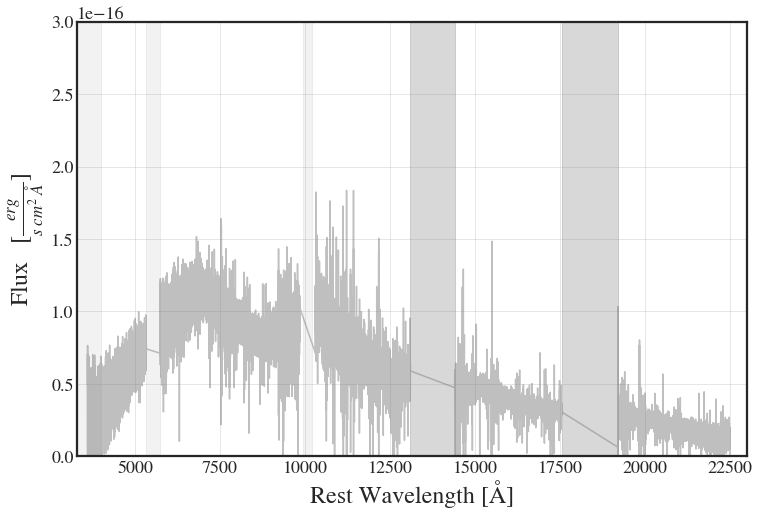

In [7]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [8]:
csts.c

<<class 'astropy.constants.codata2018.CODATA2018'> name='Speed of light in vacuum' value=299792458.0 uncertainty=0.0 unit='m / s' reference='CODATA 2018'>

In [9]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, ratio_vel = 1, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA, ratio_vel = ratio_vel)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32, 
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, ratio_vel = 1): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    ratio_vel = v["ratio_vel"]
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, ratio_vel=ratio_vel)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [10]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

In [13]:
p = lmfit.Parameters()
OB = 'OB2'
with open("./data/%s_with_assym_init.json"%OB, 'r') as infile:
    p.load(infile)

start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

Time elapsed: 1.7649559060732523


In [30]:
lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=2.42), #p['ve'], p['vphot']


(36.02908424739678,)

In [34]:
mi2.params

name,value,initial value,min,max,vary
T,3911.24016,3920,2500.00000,7500.00000,True
N,2.8270e-29,2.7e-29,-inf,inf,True
vphot,0.21788750,0.248,0.00000000,1.00000000,True
vmax,0.26637228,0.279,0.00000000,1.00000000,True
t0,212400.000,212400,-inf,inf,False
tau,3.15934271,1.9,0.00000000,20.0000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.15471795,0.2,0.00000000,0.20000000,True
occult,0.23325911,1.26,0.10000000,10.0000000,True
amp1,0.52297644,0.52,0.01000000,5.00000000,True


In [36]:
with open("./data/%s_assymetry_090.json"%OB, 'w') as outfile:
    mi2.params.dump(outfile)

In [37]:
p = lmfit.Parameters()
OB = 'OB2'

#with open("./data/%s_3.json"%OB, 'w') as outfile:
#    mi2.params.dump(outfile)p = lmfit.Parameters()
with open("./Data/%s_assymetry_090.json"%OB, 'r') as infile:
    p.load(infile)

#p
lum_dist_arr(p['N'],p['vphot'],n_days=2.42), p['ve'], p['vphot']
p['ratio_vel'].value = 0.90

# OB1_1 : free ve
# OB1_2 : free ve
# OB1_3 : fixed ve [0,0.1]
p

name,value,initial value,min,max,vary
T,3911.24016,3920,2500.00000,7500.00000,True
N,2.8270e-29,2.7e-29,-inf,inf,True
vphot,0.21788750,0.248,0.00000000,1.00000000,True
vmax,0.26637228,0.279,0.00000000,1.00000000,True
t0,212400.000,212400,-inf,inf,False
tau,3.15934271,1.9,0.00000000,20.0000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.15471795,0.2,0.00000000,0.20000000,True
occult,0.23325911,1.26,0.10000000,10.0000000,True
amp1,0.52297644,0.52,0.01000000,5.00000000,True


In [11]:
pickle_in = open("./data/OB2/OB2_3_peaks_assym_20x30000.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['ve'].max = 1
p

name,value,standard error,relative error,initial value,min,max,vary
T,3924.64733,2.15043189,(0.05%),3919.442593743376,2500.00000,7500.00000,True
N,2.7969e-29,8.6427e-32,(0.31%),2.792226259206946e-29,-inf,inf,True
vphot,0.24795625,6.8634e-04,(0.28%),0.22634676570969986,0.00000000,1.00000000,True
vmax,0.27935578,7.0563e-04,(0.25%),0.26890392660024365,0.00000000,1.00000000,True
t0,212400.000,,(0.25%),212400,-inf,inf,False
tau,6.13651373,1.27516467,(20.78%),2.6324069093755407,0.00000000,20.0000000,True
vref,0.00000000,,(20.78%),0.0,0.00000000,1.00000000,False
ve,0.16952007,0.02124131,(12.53%),0.1997514021444407,0.00000000,1.00000000,True
occult,1.30981380,0.04895969,(3.74%),1.241899210606824,0.10000000,10.0000000,True
amp1,0.53715591,0.00994753,(1.85%),0.5652146699991472,0.01000000,5.00000000,True


#### Markov Chain Monto Carlo to sample distribution


In [12]:
mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 20 #v = p.valuesdict()
res2 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2000, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )#wqeaaaaaaas

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 2000/2000 [23:34<00:00,  1.41it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [154.84350283 140.75087809 218.08600084 218.13669993 227.44022272
 168.19629426 230.52906651 155.24099448 196.01644376 105.47651996]
Time elapsed [hours]: 0.39399681170781453


In [13]:
#with open("./Data/OB1/OB1_3_peaks_100walkers.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile)

flat = res2.flatchain


0.9970841955386798 0.998306014009963 0.9991329946778525


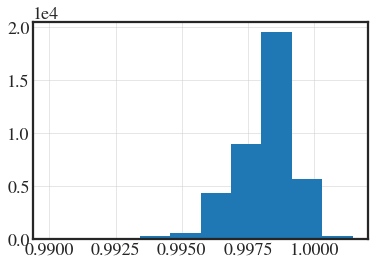

In [14]:
plt.hist(flat['ratio_vel'])
print(np.percentile(flat['ratio_vel'],15.9), np.median(flat['ratio_vel']), np.percentile(flat['ratio_vel'],100-15.9))

(0.0, 40000.0)

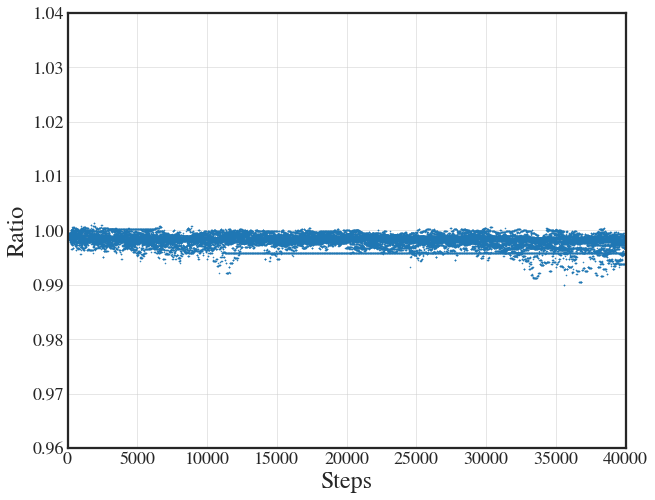

In [15]:
plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['vphot'])), flat['ratio_vel'], s=0.3, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')#, plt.xlim(0, 200000)
plt.ylim(0.96, 1.04)
plt.xlim(0, 2000*20)#600000/20)
#plt.xscale('log'), plt.xlim(1000,len(flat['vphot']))
#plt.ylim(1)
#plt.savefig('Pictures/Assym_transient_epoch2_090.png', dpi=300)

In [16]:
epsabs = 1
#np.std(flat['ratio_vel'])

0.0011845933982102777

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=0.1 ) 


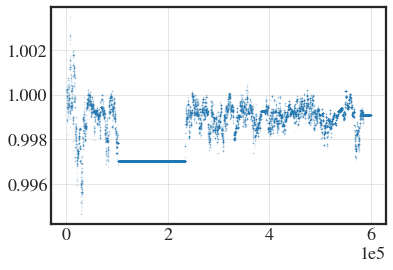

In [27]:
plt.scatter( np.arange(len(flat['vphot']))[::20], flat['ratio_vel'][::20], s=0.3, alpha=0.1 ) 


In [45]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,5407.62936,1.05940253,(0.02%),5407.285407039741,2500.00000,7500.00000,True
N,1.3754e-29,1.7334e-32,(0.13%),1.3749516116419793e-29,-inf,inf,True
vphot,0.28113535,0.00831228,(2.96%),0.28246663134832684,0.00000000,1.00000000,True
vmax,0.33993437,0.00345718,(1.02%),0.3389655495810009,0.00000000,1.00000000,True
t0,126000.000,,(1.02%),126000,-inf,inf,False
tau,2.06110910,0.17428410,(8.46%),2.09305831343341,0.00000000,100.000000,True
vref,0.00000000,,(8.46%),0.0,0.00000000,1.00000000,False
ve,0.28673790,0.03807846,(13.28%),0.2869611642102523,0.00000000,1.00000000,True
occult,0.01455842,0.00951137,(65.33%),0.019449846793080927,0.00000000,2.00000000,True
amp1,0.28000000,,(65.33%),0.28,0.00000000,1.00000000,False


In [16]:
#with open("./Data/OB2/OB2_3_peaks_assym_20x2000.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

##### Plot d_l

In [11]:
pickle_in = open("./data/OB2/OB2_3_peaks_assym_20x2000.pkl","rb")
res2 = pickle.load(pickle_in)
#p = res2.params
#lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot']

42.99264351707265 42.84422093244876 43.1445202783943
42.99275978345795 42.84393318986127 43.145141782901696


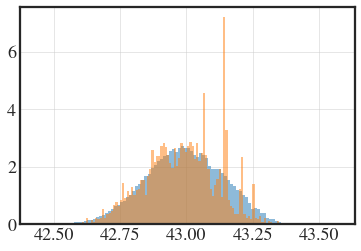

In [13]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42) #* np.sqrt(np.pi)
dl = dl*np.random.uniform(low=1.427, high=1.433, size=len(dl))/1.43
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 
nwalkers = 20
steady = int(1000*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=2.42) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [26]:
np.percentile(lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42), 100-15.9)

43.145141782901696

In [29]:
np.percentile(flat['ratio_vel'], 15.9)

0.9970841955386798

In [69]:
import corner

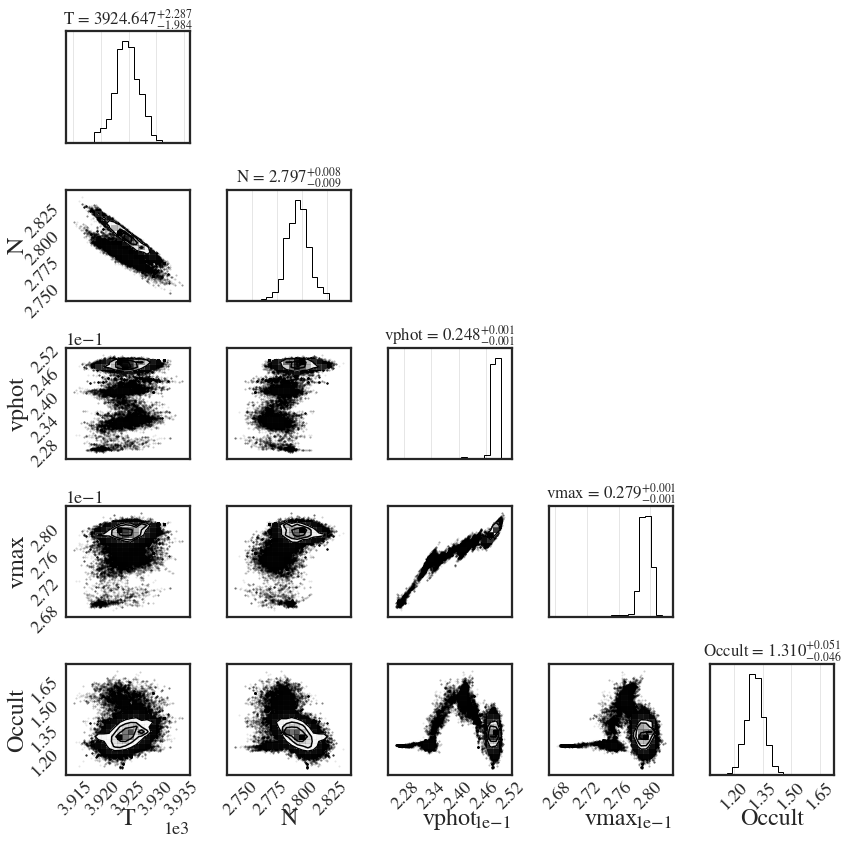

In [50]:
fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult']]).T, 
            labels=['T', 'N', 'vphot','vmax', 'Occult'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

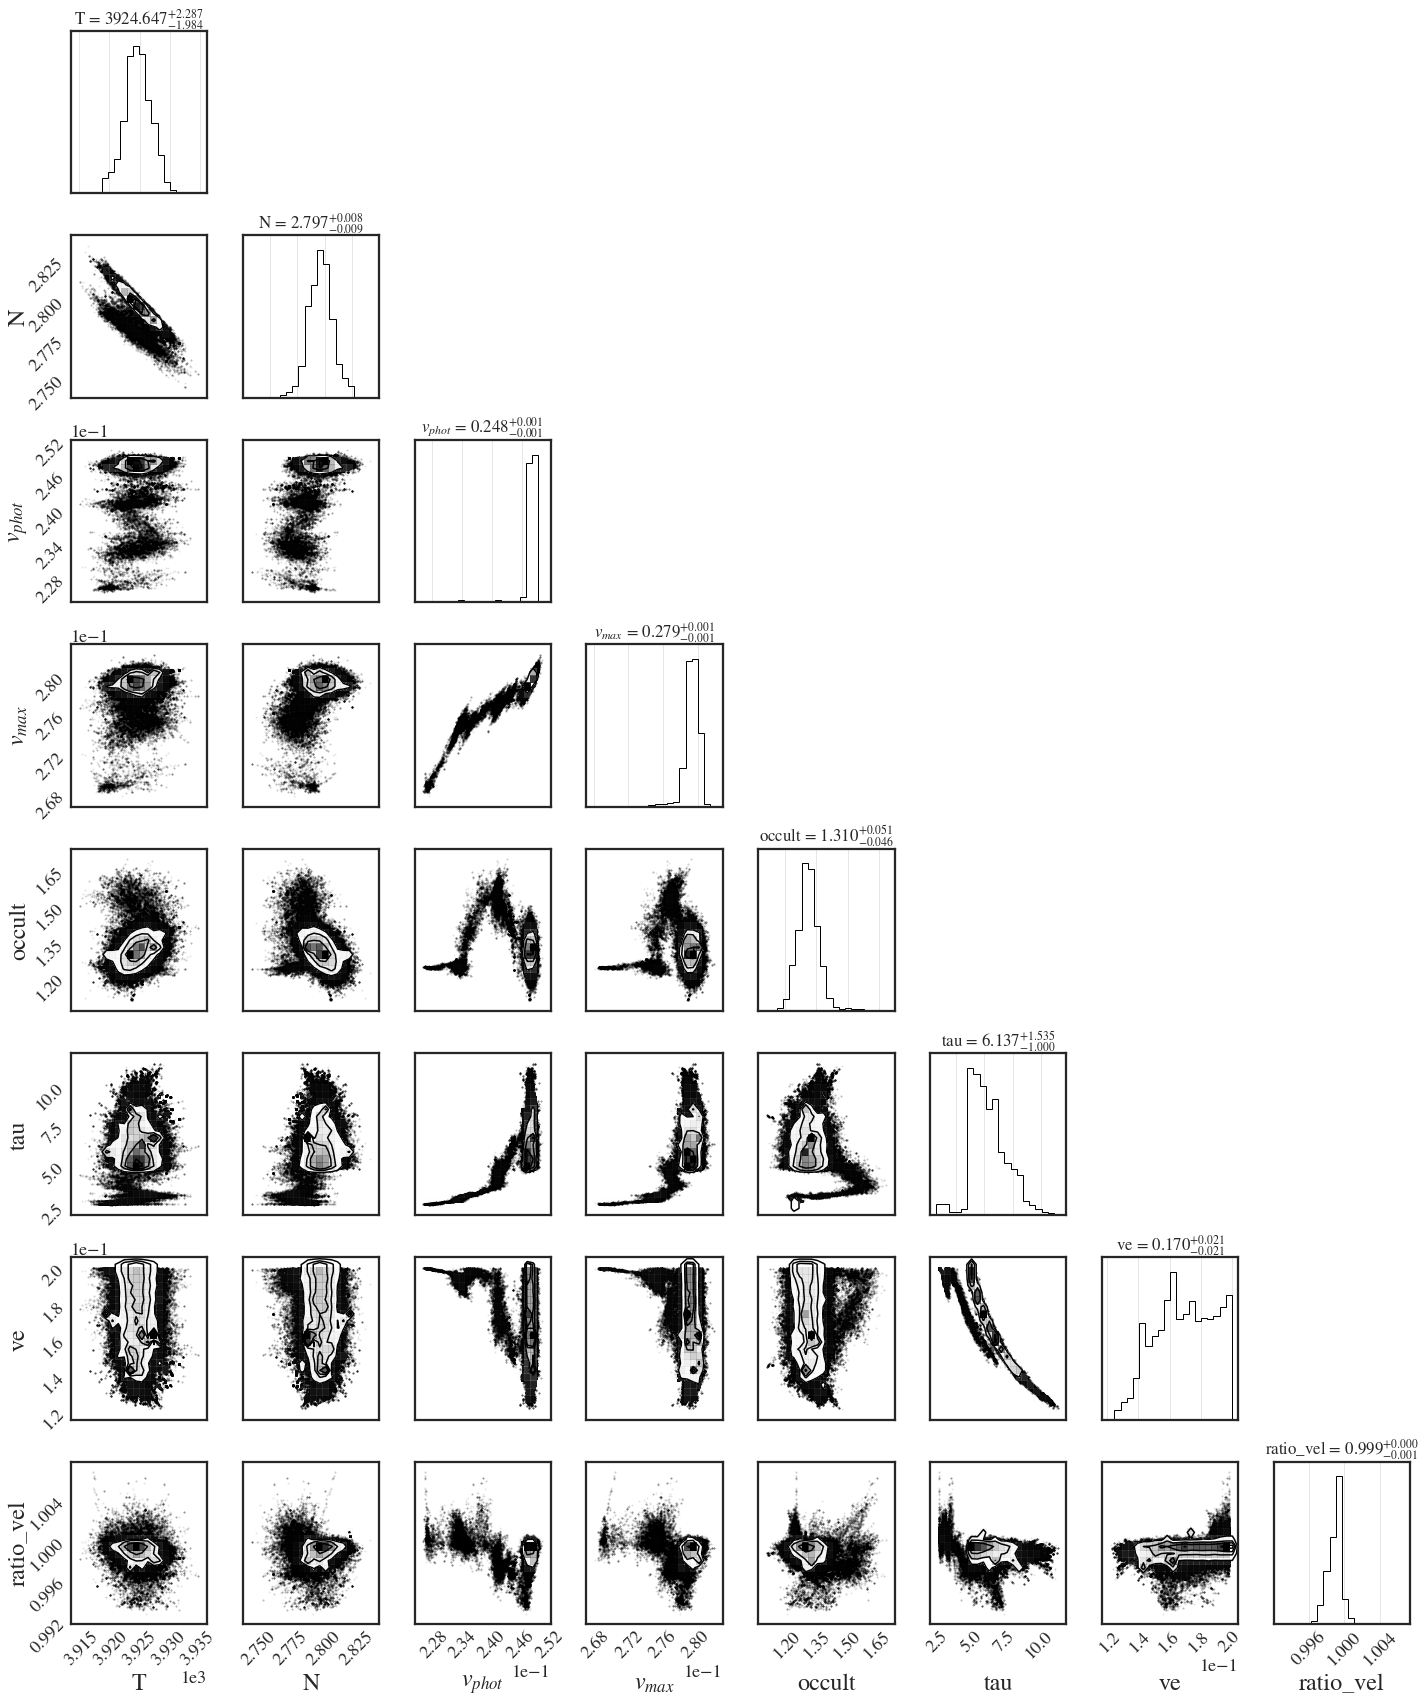

In [70]:
n_box = 8
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve'], flat['ratio_vel']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve', 'ratio_vel'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_large_n.png', dpi=300)

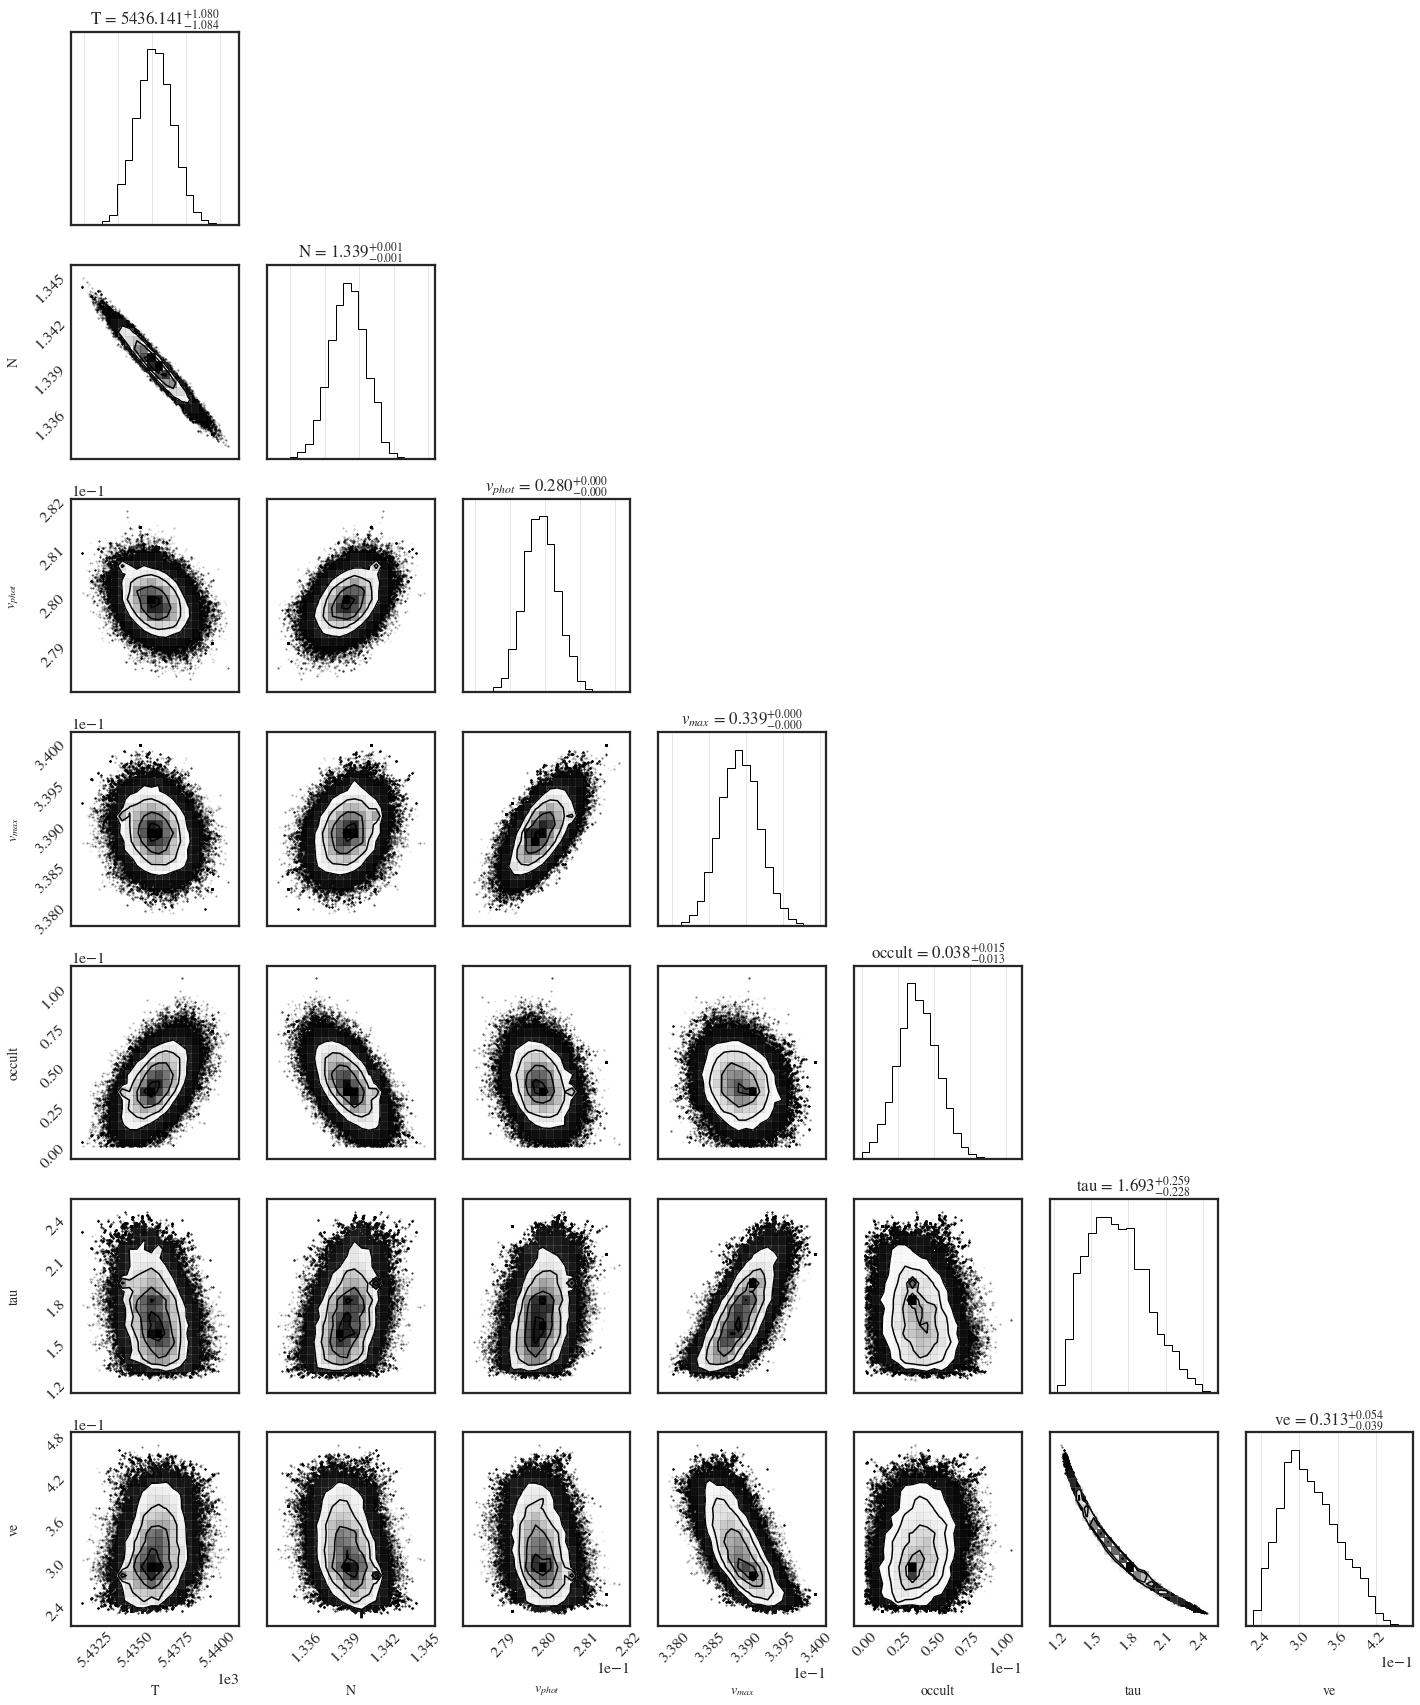

In [20]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_large_n.png', dpi=300)

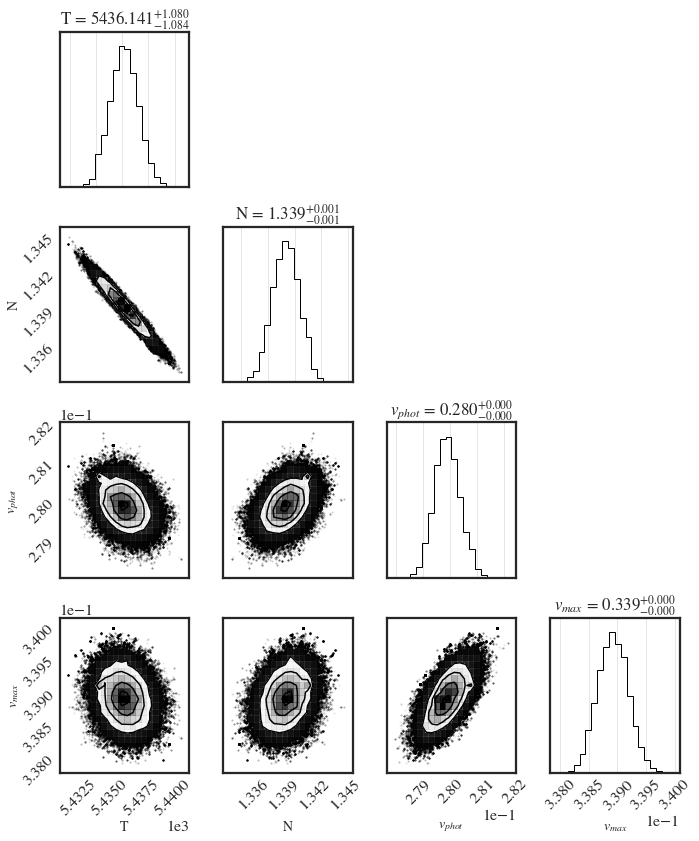

In [21]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_small_n.png', dpi=300)

In [60]:
## day 1
1+(23-12)/24+(21-41)/24/60

#23:45:35
#23:34:00
#23:22:22
#23:57:12
        
dtime1 = 1 + (23-12)/24 + (np.mean([16])-41)/(24*60)
dtime1

1.440972222222222

In [61]:
## day 2
2+(23-12)/24+(28-41)/24/60

# 23:53:42
# 23:58:38
# 23:38:35
# 23:28:45

dtime2 = 2 + (23-12)/24 + (np.mean([23])-41)/(24*60)
dtime2

2.4458333333333333

In [54]:
3+(24-12)/24+(5-41)/24/60

#  23:25:24
#  23:37:01
#  23:48:40
#  00:23:28
#  00:11

dtime3 = 3 + (23-12)/24 + (np.mean([25, 37, 48, 23+60, 11+60])-41)/(24*60)
dtime3

3.466527777777778

In [58]:
30/24/60

0.020833333333333332

In [62]:
3+(24-12)/24+(5-41)/24/60

#  23:50
#  23:25
#  23:30
#  23:35

dtime4 = 4 + (23-12)/24 + (np.mean([13])-41)/(24*60)
dtime4

4.438888888888888

In [31]:
## day 4
4+(23-12)/24+(50-41)/24/60

4.464583333333333

In [40]:
30/24/60

0.020833333333333332